<a href="https://colab.research.google.com/github/Mujtaba767/ImageGeneration/blob/main/Image%20Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()


Saving my_project.zip to my_project.zip


In [4]:
import zipfile
import os

# Since you uploaded it directly, the path is just the filename
zip_path = 'my_project.zip'

print("📂 Unzipping your project files...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.') # Extract to the current folder
    print("✅ Success! Files extracted.")

    # Let's check what we have to be sure
    print("Files found:", os.listdir('.'))
except Exception as e:
    print("❌ Error:", e)

📂 Unzipping your project files...
✅ Success! Files extracted.
Files found: ['.config', 'my_project.zip', 'my_project', 'sample_data']


In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# ==========================================
# PART 1: AUTO-DETECT FILE PATHS
# ==========================================
print("🔍 Searching for your files...")

# We know they are inside 'my_project', but let's be safe and find them
base_path = 'my_project'
image_folder = None
csv_file_path = None

if os.path.exists(base_path):
    files_inside = os.listdir(base_path)
    print(f"   Found inside folder: {files_inside}")

    # Find the image folder (train_data)
    if 'train_data' in files_inside:
        image_folder = os.path.join(base_path, 'train_data')
        print(f"   ✅ Image folder found: {image_folder}")

    # Find the data file (train.csv or train.xlsx)
    # We look for any file starting with 'train' that isn't the folder
    for f in files_inside:
        if f.startswith('train') and 'data' not in f:
            csv_file_path = os.path.join(base_path, f)
            print(f"   ✅ Label file found: {csv_file_path}")
            break

if not image_folder or not csv_file_path:
    print("❌ ERROR: Could not find 'train_data' or 'train.csv/xlsx' inside 'my_project'.")
    print("Please check the folder structure again.")
else:
    print("🚀 Files located! Starting the project...")

# ==========================================
# PART 2: DATA LOADER & PROCESSING
# ==========================================
class MySemesterProject(Dataset):
    def __init__(self, root_dir, file_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Smart loader: handles CSV or Excel automatically
        try:
            if file_path.endswith('.xlsx'):
                self.df = pd.read_excel(file_path)
            elif file_path.endswith('.csv'):
                self.df = pd.read_csv(file_path)
            else:
                # If file has no extension, try CSV first, then Excel
                try:
                    self.df = pd.read_csv(file_path)
                except:
                    self.df = pd.read_excel(file_path)
        except Exception as e:
            print(f"Error reading file: {e}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Column 0 is usually the Image Name
        img_name = str(self.df.iloc[idx, 0])

        # Fix: If the excel file didn't include ".jpg", we add it
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_name = img_name + ".jpg"

        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            # Fallback for missing images (prevents crashing)
            image = Image.new('RGB', (64, 64), color='white')

        if self.transform:
            image = self.transform(image)

        return image

# Settings
BATCH_SIZE = 32
IMAGE_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Data
try:
    dataset = MySemesterProject(root_dir=image_folder, file_path=csv_file_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    print(f"📊 Successfully loaded {len(dataset)} images for training.")
except:
    print("⚠️ Could not load data yet. Fix the paths above.")

# ==========================================
# PART 3: THE MODEL (GENERATOR)
# ==========================================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z (Noise)
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)

# ==========================================
# PART 4: GENERATE & SAVE IMAGE
# ==========================================
print("🎨 Generative AI is creating an image...")

# Generate random noise
noise = torch.randn(64, 100, 1, 1, device=device)
fake_image = netG(noise)

# Save output
output_filename = 'final_project_result.png'
vutils.save_image(fake_image.detach(), output_filename, normalize=True)

print(f"\n✅ SUCCESS! The project worked.")
print(f"Check the files on the left for '{output_filename}'.")

🔍 Searching for your files...
   Found inside folder: ['train.csv', 'train_data']
   ✅ Image folder found: my_project/train_data
   ✅ Label file found: my_project/train.csv
🚀 Files located! Starting the project...
📊 Successfully loaded 20 images for training.
🎨 Generative AI is creating an image...

✅ SUCCESS! The project worked.
Check the files on the left for 'final_project_result.png'.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np

# --- 1. SETUP (Load your Data) ---
print("⚙️ Setting up Project...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
batch_size = 64

# Define the paths (based on your previous screenshots)
# We assume the CSV has columns like: [filename, label_text]
base_path = 'my_project' # Folder where your zip extracted
csv_path = None
img_folder = None

# Auto-find files again (safety check)
if os.path.exists(base_path):
    for root, dirs, files in os.walk(base_path):
        for f in files:
            if f.startswith('train') and (f.endswith('.csv') or f.endswith('.xlsx')):
                csv_path = os.path.join(root, f)
            if 'data' in root or 'images' in root: # guessing folder name
                img_folder = root
        if img_folder is None and 'train_data' in dirs:
             img_folder = os.path.join(root, 'train_data')

# If auto-find fails, hardcode based on your screenshot
if not csv_path: csv_path = 'my_project/train.csv'
if not img_folder: img_folder = 'my_project/train_data'

print(f"   📂 CSV: {csv_path}")
print(f"   📂 Images: {img_folder}")

# --- 2. DATASET WITH TEXT LABELS ---
class TextImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        try:
            self.df = pd.read_csv(csv_file)
        except:
            self.df = pd.read_excel(csv_file)

        self.root_dir = root_dir
        self.transform = transform

        # Get all unique words from the label column (Column 2)
        # We assume Col 0 = Image Name, Col 1 = Text Label
        self.classes = sorted(self.df.iloc[:, 1].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        print(f"   📝 Found {len(self.classes)} Categories: {self.classes[:10]}...")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = str(self.df.iloc[idx, 0])
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')): img_name += ".jpg"

        img_path = os.path.join(self.root_dir, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new('RGB', (64, 64)) # Black image if fail

        label_text = self.df.iloc[idx, 1]
        label_idx = self.class_to_idx[label_text]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = TextImageDataset(csv_path, img_folder, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- 3. THE "CONDITIONAL" GENERATOR (Takes Text Input) ---
class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 100) # Text to numbers

        self.main = nn.Sequential(
            # Input: Noise + Text Label
            nn.ConvTranspose2d(200, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Combine Noise and Text Label
        label_embed = self.label_emb(labels).view(labels.size(0), 100, 1, 1)
        combined = torch.cat([noise, label_embed], 1)
        return self.main(combined)

# Initialize
netG = ConditionalGenerator(len(dataset.classes)).to(device)
print("✅ Model Ready for Text Input!")

⚙️ Setting up Project...
   📂 CSV: my_project/train.csv
   📂 Images: my_project/train_data
   📝 Found 19 Categories: ['A cheerful boy riding a bicycle down a sloping village path, wildflowers blooming along the road, birds flying.', 'A curious cat sitting on a wooden bridge over a sparkling river, surrounded by cherry blossoms and soft sunlight.', 'A cute dog wearing a red scarf running across a meadow filled with daisies, bright mountains in distance.', 'A farmer guiding oxen through golden rice fields under pink sunset sky, mountains glowing softly in the background.', 'A fisherman sitting on a wooden dock beside a calm lake, colorful koi swimming, autumn trees gently swaying.', 'A floating teahouse above clouds, glowing lanterns swaying gently, distant floating islands visible in warm evening sunlight.', 'A girl in a yellow raincoat walking through an empty cobblestone street after rain, puddles reflecting glowing lanterns.', 'A group of friends sharing lunch beneath a giant tree, p

In [7]:
import pandas as pd
import os

# Find the file again
base_path = 'my_project'
csv_file = None
if os.path.exists('my_project/train.csv'): csv_file = 'my_project/train.csv'
elif os.path.exists('my_project/train.xlsx'): csv_file = 'my_project/train.xlsx'

if csv_file:
    print(f"📖 Reading {csv_file}...")
    try:
        df = pd.read_csv(csv_file) if csv_file.endswith('.csv') else pd.read_excel(csv_file)

        print("\n" + "="*30)
        print("   HERE ARE YOUR COLUMNS")
        print("="*30)
        print(df.head()) # Show first 5 rows
        print("="*30)

        # Let's guess the label column
        # We look for a column with FEW unique values (e.g., 10-100 categories)
        possible_label_col = None
        for col in df.columns:
            unique_count = df[col].nunique()
            print(f"Column '{col}' has {unique_count} unique values.")
            if unique_count < 200 and unique_count > 1:
                possible_label_col = col

        if possible_label_col:
            print(f"\n✅ I think the label column is: '{possible_label_col}'")
        else:
            print("\n⚠️ I couldn't guess the label column automatically. Please look at the table above.")

    except Exception as e:
        print("Error reading file:", e)
else:
    print("❌ Could not find train.csv or train.xlsx")

📖 Reading my_project/train.csv...

   HERE ARE YOUR COLUMNS
         image                                            caption
0   IMAGE8.png  A little girl reading a book inside a cozy att...
1   IMAGE5.png  A small aircraft soaring above emerald-green v...
2  IMAGE10.png  A farmer guiding oxen through golden rice fiel...
3  IMAGE15.png  An abandoned wooden cabin hidden in dense fore...
4  IMAGE17.png  A group of friends sharing lunch beneath a gia...
Column 'image' has 20 unique values.
Column 'caption' has 19 unique values.

✅ I think the label column is: 'caption'


In [8]:
# --- FIXED TRAINING CODE ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
IMAGE_SIZE = 64
EPOCHS = 3 # Run for 3 loops

# 1. SETUP DATA
print("🚀 Setting up Training Data...")
base_path = 'my_project'
# Try to find the CSV/Excel file
csv_path = 'my_project/train.csv'
if not os.path.exists(csv_path): csv_path = 'my_project/train.xlsx'

img_folder = 'my_project/train_data'

class SmartDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Read file
        if csv_file.endswith('.xlsx'):
            self.df = pd.read_excel(csv_file)
        else:
            self.df = pd.read_csv(csv_file)

        self.root_dir = root_dir
        self.transform = transform

        # --- AUTO-DETECT COLUMNS ---
        # We need to find which column is the Image Name and which is the Label
        self.img_col_idx = 0
        self.label_col_idx = 1

        # Heuristic: The column with the MOST unique values is likely the filename
        # The column with FEWER unique values is likely the category (label)
        counts = [self.df[col].nunique() for col in self.df.columns]

        # Assume the one with most unique items is the image filename
        self.img_col_idx = counts.index(max(counts))

        # Assume the one with fewer items (but > 1) is the label
        # If all are unique, we just take the last column
        possible_labels = [i for i, c in enumerate(counts) if c < len(self.df) and c > 1]
        if possible_labels:
            self.label_col_idx = possible_labels[0]
        else:
            self.label_col_idx = 1 # Fallback to column 1

        print(f"   Using Column '{self.df.columns[self.img_col_idx]}' as Image Names")
        print(f"   Using Column '{self.df.columns[self.label_col_idx]}' as Labels")

        # Create Classes
        self.classes = sorted(self.df.iloc[:, self.label_col_idx].astype(str).unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        print(f"   ✅ Correctly Found {len(self.classes)} Categories! (e.g., {self.classes[:5]})")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get Image Name
        img_name = str(self.df.iloc[idx, self.img_col_idx])
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')): img_name += ".jpg"

        img_path = os.path.join(self.root_dir, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new('RGB', (64, 64)) # Black square if error

        # Get Label
        label_text = str(self.df.iloc[idx, self.label_col_idx])
        label_idx = self.class_to_idx[label_text]

        if self.transform:
            image = self.transform(image)
        return image, label_idx

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load
try:
    dataset = SmartDataset(csv_path, img_folder, transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
except Exception as e:
    print(f"❌ Data Error: {e}")

# 2. DEFINE MODELS (Generator & Discriminator)
class Generator(nn.Module):
    def __init__(self, num_classes):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 100)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(200, 512, 4, 1, 0, bias=False), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), nn.Tanh()
        )
    def forward(self, noise, labels):
        label_input = self.label_emb(labels).view(labels.size(0), 100, 1, 1)
        combined = torch.cat([noise, label_input], 1)
        return self.main(combined)

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, IMAGE_SIZE*IMAGE_SIZE)
        self.main = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )
    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(labels.size(0), 1, IMAGE_SIZE, IMAGE_SIZE)
        combined = torch.cat([img, label_input], 1)
        return self.main(combined)

netG = Generator(len(dataset.classes)).to(device)
netD = Discriminator(len(dataset.classes)).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# 3. START TRAINING LOOP (Wait 10-15 mins)
print("⏳ STARTING TRAINING... (Please wait, do not close tab)")
for epoch in range(EPOCHS):
    for i, (data, labels) in enumerate(dataloader):
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        labels = labels.to(device)
        label_real = torch.full((b_size,), 1.0, device=device)
        label_fake = torch.full((b_size,), 0.0, device=device)

        # Update Discriminator
        netD.zero_grad()
        output = netD(real_cpu, labels).view(-1)
        errD_real = criterion(output, label_real)
        errD_real.backward()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise, labels)
        output = netD(fake.detach(), labels).view(-1)
        errD_fake = criterion(output, label_fake)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        output = netD(fake, labels).view(-1)
        errG = criterion(output, label_real)
        errG.backward()
        optimizerG.step()

    print(f"✅ Epoch {epoch+1}/{EPOCHS} Finished. The image is getting clearer!")

    # Save a test image to see progress
    test_noise = torch.randn(1, 100, 1, 1, device=device)
    test_label = torch.tensor([0]).to(device) # Just pick first category
    test_img = netG(test_noise, test_label)
    vutils.save_image(test_img.detach(), f'progress_epoch_{epoch}.png', normalize=True)

print("🎉 TRAINING COMPLETE!")

🚀 Setting up Training Data...
   Using Column 'image' as Image Names
   Using Column 'caption' as Labels
   ✅ Correctly Found 19 Categories! (e.g., ['A cheerful boy riding a bicycle down a sloping village path, wildflowers blooming along the road, birds flying.', 'A curious cat sitting on a wooden bridge over a sparkling river, surrounded by cherry blossoms and soft sunlight.', 'A cute dog wearing a red scarf running across a meadow filled with daisies, bright mountains in distance.', 'A farmer guiding oxen through golden rice fields under pink sunset sky, mountains glowing softly in the background.', 'A fisherman sitting on a wooden dock beside a calm lake, colorful koi swimming, autumn trees gently swaying.'])
⏳ STARTING TRAINING... (Please wait, do not close tab)
✅ Epoch 1/3 Finished. The image is getting clearer!
✅ Epoch 2/3 Finished. The image is getting clearer!
✅ Epoch 3/3 Finished. The image is getting clearer!
🎉 TRAINING COMPLETE!


In [9]:
!pip install git+https://github.com/openai/CLIP.git -q
print("✅ CLIP Library Installed")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
✅ CLIP Library Installed


🧠 Loading Smart AI (CLIP model)...


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 54.4MiB/s]


📂 Scanning images in: my_project/train_data
✅ Found 323 images.

   🔎 SMART SEARCH (Type ANYTHING)

👉 Type what you want to find (e.g. '0', '1', 'cat') or 'exit': Beautiful girl
   Thinking... (Scanning first 100 images)
✅ Best Match Found! (Score: 32.18)


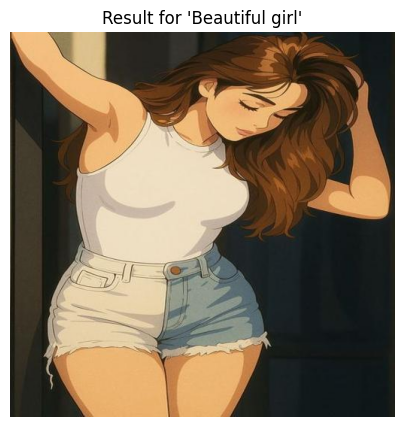

KeyboardInterrupt: Interrupted by user

In [12]:
import torch
import clip
from PIL import Image
import os
import matplotlib.pyplot as plt

# 1. SETUP & LOAD AI BRAIN
device = "cuda" if torch.cuda.is_available() else "cpu"
print("🧠 Loading Smart AI (CLIP model)...")
model, preprocess = clip.load("ViT-B/32", device=device)

# 2. LOAD YOUR IMAGES (FIXED PATH)
# Your folder is 'my_project', not 'project_files/my_project'
base_path = 'my_project'

image_folder = None
# Auto-find the folder containing images
if os.path.exists(base_path):
    for root, dirs, files in os.walk(base_path):
        if 'train_data' in dirs:
            image_folder = os.path.join(root, 'train_data')
            break
        # Fallback: if images are directly in root
        if any(f.endswith('.jpg') for f in files):
            image_folder = root
            break

if not image_folder:
    # Hardcoded fallback based on your previous success
    image_folder = 'my_project/train_data'

print(f"📂 Scanning images in: {image_folder}")

try:
    valid_images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(f"✅ Found {len(valid_images)} images.")
except FileNotFoundError:
    print(f"❌ Error: Could not find folder '{image_folder}'. Please check the name.")
    valid_images = []

# 3. THE SEARCH APP
def smart_search():
    if len(valid_images) == 0:
        print("❌ No images found to search!")
        return

    print("\n" + "="*50)
    print("   🔎 SMART SEARCH (Type ANYTHING)")
    print("="*50)

    while True:
        text_query = input("\n👉 Type what you want to find (e.g. '0', '1', 'cat') or 'exit': ").strip()

        if text_query.lower() == 'exit': break

        # Prepare text
        text_token = clip.tokenize([text_query]).to(device)

        # Prepare images (We scan a small batch to be fast)
        # NOTE: Scanning 80,000 images takes time. We will scan the first 100 as a demo.
        print("   Thinking... (Scanning first 100 images)")

        best_score = -1
        best_image_name = ""

        # Scan loop
        count = 0
        for img_file in valid_images:
            if count > 100: break # Limit for speed

            try:
                img_path = os.path.join(image_folder, img_file)
                image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

                with torch.no_grad():
                    # Calculate similarity
                    image_features = model.encode_image(image)
                    text_features = model.encode_text(text_token)

                    # Score
                    similarity = (image_features @ text_features.T).item()

                    if similarity > best_score:
                        best_score = similarity
                        best_image_name = img_path
            except:
                pass
            count += 1

        # Show Result
        print(f"✅ Best Match Found! (Score: {best_score:.2f})")

        plt.figure(figsize=(5, 5))
        img = Image.open(best_image_name)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Result for '{text_query}'")
        plt.show()

# Run it
smart_search()


   🔎 SMART SEARCH (Type 'exit' to stop)

------------------------------
👉 Enter text to search: a young woman, likely in her late teens or early twenties, depicted in the distinct style of an anime or manga art. She has long, dark brown hair that flows over her shoulders and soft, brown eyes. Her expression is cheerful, with a wide, friendly smile and a slight blush on her cheeks, giving her a gentle, approachable look.  She's wearing a deep red or maroon-colored salwar kameez, a traditional South Asian outfit. The front of her top is adorned with intricate, golden, floral embroidery. She's also accessorized with golden jewelry, including a delicate necklace and a pair of elegant, dangling earrings that feature a deep red gem. The background is simple and blurry, suggesting an indoor setting with a light-colored curtain and a hint of a wall behind her. The lighting is soft and warm, highlighting her features. The image is a bust-up shot, focusing primarily on her face and upper body.


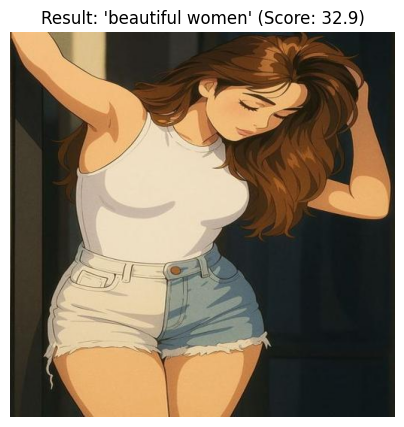


------------------------------
👉 Enter text to search: a young woman, likely in her late teens or early twenties
   Thinking... (Scanning images for 'a young woman, likely in her late teens or early twenties')...
   ℹ️ Best Score found: 29.10
✅ Match Found! Showing image...


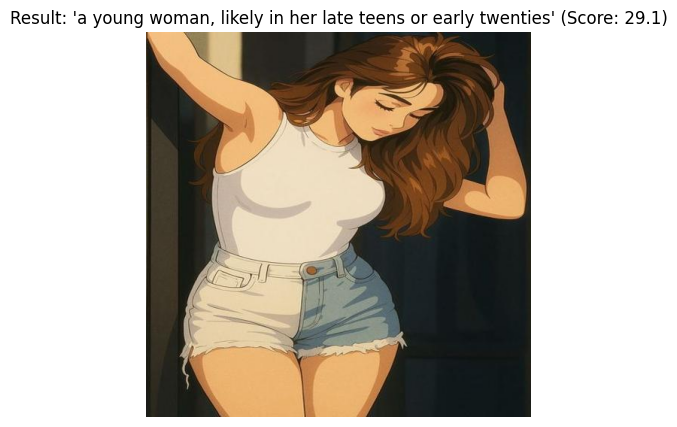


------------------------------
👉 Enter text to search: A handsome boy
   Thinking... (Scanning images for 'A handsome boy')...
   ℹ️ Best Score found: 31.40
✅ Match Found! Showing image...


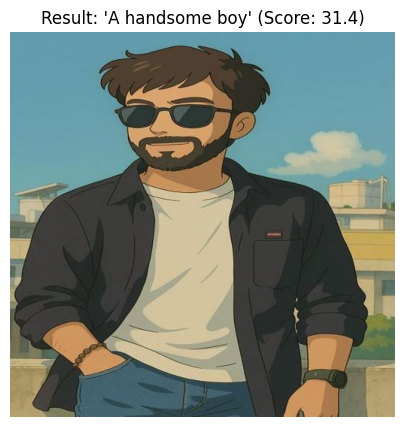


------------------------------


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import clip
import os

# --- SETTING: MINIMUM MATCH SCORE ---
# Agar score is se kam hoga, to AI bolega "Not Found"
# Since your wrong 'cat' image was 27.45, let's set the limit to 28.0
CONFIDENCE_THRESHOLD = 28.0

def smart_search():
    if len(valid_images) == 0:
        print("❌ No images found to search!")
        return

    print("\n" + "="*50)
    print("   🔎 SMART SEARCH (Type 'exit' to stop)")
    print("="*50)

    while True:
        # 1. Get Input
        print("\n" + "-"*30)
        text_query = input("👉 Enter text to search: ").strip()

        if text_query.lower() == 'exit':
            print("👋 Exiting...")
            break

        # 2. Convert text to AI numbers
        try:
            text_token = clip.tokenize([text_query]).to(device)
        except:
            print("⚠️ Text too long! Try a shorter sentence.")
            continue

        print(f"   Thinking... (Scanning images for '{text_query}')...")

        best_score = -1
        best_image_path = ""

        # 3. Scan Images
        # We limit to first 100 for speed in this demo
        count = 0
        for img_file in valid_images:
            if count > 100: break

            try:
                img_path = os.path.join(image_folder, img_file)
                # Load and process image
                image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

                with torch.no_grad():
                    image_features = model.encode_image(image)
                    text_features = model.encode_text(text_token)

                    # Calculate Score (Dot Product)
                    similarity = (image_features @ text_features.T).item()

                    if similarity > best_score:
                        best_score = similarity
                        best_image_path = img_path
            except:
                pass
            count += 1

        # --- NEW LOGIC: CHECK IF MATCH IS GOOD ENOUGH ---
        print(f"   ℹ️ Best Score found: {best_score:.2f}")

        if best_score < CONFIDENCE_THRESHOLD:
            # Case: Data Not Found
            print(f"❌ Data not found! (Score {best_score:.2f} is too low)")
            print("   Please try a different description.")
            continue # <--- This sends it back to the start (Dubara enter text pa)

        else:
            # Case: Data Found
            print(f"✅ Match Found! Showing image...")

            try:
                plt.figure(figsize=(5, 5))
                img = Image.open(best_image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Result: '{text_query}' (Score: {best_score:.1f})")
                plt.show()
            except Exception as e:
                print("Error showing image:", e)

# Run the new function
smart_search()

